<a href="https://colab.research.google.com/github/fighaz/MachineLearning_2024/blob/main/UTS_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ntl0601/casia-webface")

print("Path to dataset files:", path)

100%|██████████| 2.53G/2.53G [00:13<00:00, 195MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ntl0601/casia-webface/versions/1


Found 490623 images.


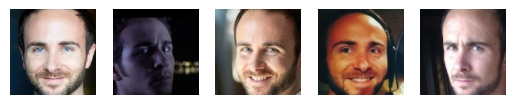

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import glob
import os
path = "/root/.cache/kagglehub/datasets/ntl0601/casia-webface/versions/1"

# Find all image files in the dataset (assuming images are in .jpg format)
image_files = glob.glob(os.path.join(path, "**/*.jpg"), recursive=True)

# Check if any images were found
if image_files:
    print(f"Found {len(image_files)} images.")

    # Display the first 5 images
    for i, image_file in enumerate(image_files[:5]):
        img = Image.open(image_file)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')

    plt.show()
else:
    print("No images found in the dataset.")


In [3]:
from sklearn.model_selection import train_test_split
import numpy as np
# Set Parameters
image_size = (32, 32)
batch_size = 32
dataset_path = "/root/.cache/kagglehub/datasets/ntl0601/casia-webface/versions/1/casia-webface"

# Extract classes manually based on folder names
class_names = os.listdir(dataset_path)
num_classes = len(class_names)
print(f"Found {num_classes} classes: {class_names}")

Found 10572 classes: ['002413', '006929', '005835', '004009', '005758', '000781', '006524', '009002', '008411', '001663', '000960', '004852', '000712', '000881', '002537', '009581', '007324', '008042', '004478', '002105', '009172', '009635', '008353', '007189', '001883', '004273', '000045', '000725', '010197', '008087', '009582', '009359', '003380', '001457', '003219', '000938', '005561', '001484', '005304', '004326', '001550', '003427', '009835', '007754', '004624', '004747', '009926', '004539', '002886', '008030', '010175', '004707', '006875', '001051', '009239', '005201', '005055', '006558', '008976', '001304', '008375', '005534', '010540', '009516', '005061', '005141', '006137', '008525', '004620', '001677', '002638', '008076', '007537', '009780', '003510', '005563', '004087', '006587', '001667', '001053', '003453', '005600', '007127', '008359', '004130', '001590', '004779', '008345', '009368', '001168', '000840', '000102', '010397', '003243', '006773', '003681', '006617', '005347'

In [4]:

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import Sequence


In [6]:
from collections import defaultdict
import cv2

dataset_path = "/root/.cache/kagglehub/datasets/ntl0601/casia-webface/versions/1/casia-webface"
IMG_SIZE = (32, 32)
BATCH_SIZE = 64
MIN_IMAGES_PER_LABEL = 100  #

# Step 1: Filter labels with minimum images
def filter_labels_by_min_images(dataset_path, min_images):
    label_counts = defaultdict(list)

    # Traverse dataset and count images per label
    for root, _, files in os.walk(dataset_path):
        label = os.path.basename(root)
        if len(files) >= min_images:
            for file in files:
                if file.endswith(".jpg"):
                    label_counts[label].append(os.path.join(root, file))

    # Create a filtered list of images and label mapping
    filtered_images = []
    label_mapping = {label: idx for idx, label in enumerate(label_counts.keys())}
    for label, files in label_counts.items():
        filtered_images.extend(files)

    return filtered_images, label_mapping

# Step 2: Preprocess image batch
def preprocess_batch(image_files, label_mapping):
    images = []
    labels = []

    for img_path in image_files:
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMG_SIZE)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img_rgb)

        # Get label based on folder name
        folder_name = os.path.basename(os.path.dirname(img_path))
        label = label_mapping[folder_name]
        labels.append(label)

    images = np.array(images) / 255.0  # Normalize images
    labels = to_categorical(labels, num_classes=len(label_mapping))  # One-hot encoding for labels

    return images, labels

# Step 3: Data generator for batching
def data_generator(file_paths, batch_size, label_mapping):
    num_samples = len(file_paths)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_paths = file_paths[offset:offset + batch_size]
            batch_images, batch_labels = preprocess_batch(batch_paths, label_mapping)
            yield batch_images, batch_labels

# Filter images by minimum count per label
filtered_images, label_mapping = filter_labels_by_min_images(dataset_path, MIN_IMAGES_PER_LABEL)

# Split data into training and validation sets
train_paths, val_paths = train_test_split(filtered_images, test_size=0.2, random_state=42)

# Initialize data generators
train_generator = data_generator(train_paths, BATCH_SIZE, label_mapping)
val_generator = data_generator(val_paths, BATCH_SIZE, label_mapping)
steps_per_epoch = len(train_paths) // BATCH_SIZE
validation_steps = len(val_paths) // BATCH_SIZE


In [7]:
# Build CNN model
from tensorflow.keras import layers, models

cnn_input = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = layers.Conv2D(32, (3, 3), activation='relu')(cnn_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
output = layers.Dense(len(label_mapping), activation='softmax')(x)

model = models.Model(inputs=cnn_input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=25,  # Adjust the number of epochs as needed
    validation_data=val_generator,
    validation_steps=validation_steps
)


Epoch 1/25
2257/2257 [==============================] - 51s 22ms/step - loss: 5.9576 - accuracy: 0.0348 - val_loss: 4.9504 - val_accuracy: 0.0923
Epoch 2/25
2257/2257 [==============================] - 49s 22ms/step - loss: 4.4017 - accuracy: 0.1628 - val_loss: 4.0125 - val_accuracy: 0.2266
Epoch 3/25
2257/2257 [==============================] - 48s 21ms/step - loss: 3.6974 - accuracy: 0.2681 - val_loss: 3.5536 - val_accuracy: 0.3101
Epoch 4/25
2257/2257 [==============================] - 49s 22ms/step - loss: 3.2959 - accuracy: 0.3416 - val_loss: 3.2600 - val_accuracy: 0.3647
Epoch 5/25
2257/2257 [==============================] - 48s 21ms/step - loss: 3.0280 - accuracy: 0.3912 - val_loss: 3.0627 - val_accuracy: 0.4011
Epoch 6/25
2257/2257 [==============================] - 48s 21ms/step - loss: 2.8344 - accuracy: 0.4275 - val_loss: 2.9512 - val_accuracy: 0.4212
Epoch 7/25
2257/2257 [==============================] - 48s 21ms/step - loss: 2.6859 - accuracy: 0.4552 - val_loss: 2.8729 -

In [8]:
print(len(label_mapping))
print(len(filtered_images))

921
180600


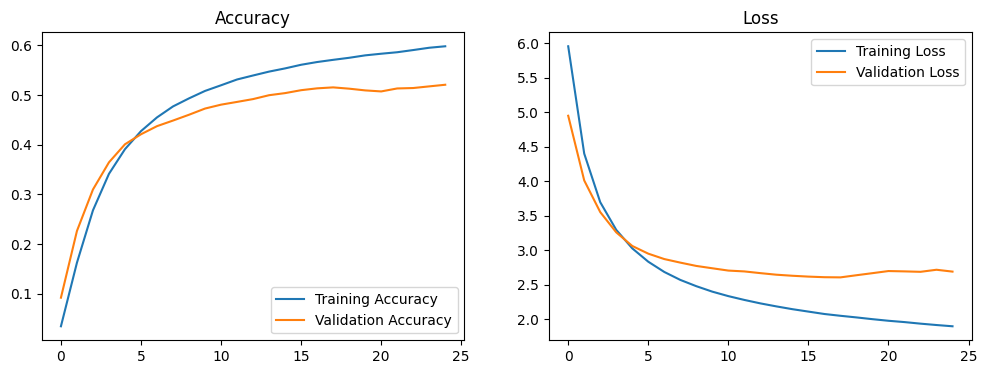

In [9]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()